<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Chapter07_UdonAI_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 07: UdonAI Data Preparation
これまでに手書き数字文字を判別するAIを開発しましたが，ここからはもう少し現実的な課題としてうどんの写真からどこのうどん屋かを予測するAIを開発してみましょう。まずは一般的な画像データから深層学習を行うためのデータを準備します。

### パッケージのインポート

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random                    # 乱数
from tqdm.notebook import tqdm   # プログレスバーの表示
import os

### Googleドライブのマウント
Googleドライブをマウントし，ファイルにアクセスできるようにしてください。

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


googleドライブ内の`DL_Lecture_202107`ディレクトリを作業ディレクトリ`working_dir`として設定します。

In [3]:
working_dir = "/content/drive/MyDrive/DL_Lecture_202107"

### データセット（zipファイル）の解凍
今回使用するデータセットは，```udon10_dataset.zip```としてまとめてあります。以下のセルを実行してzipファイルを解凍してください。少し時間がかかりますが，解凍が終わると左のファイルタブに`udon10_datasetの`ディレクトリが生成されます。

In [4]:
zip_path = os.path.join(working_dir, "udon10_dataset.zip")    # zip_pathの作成
os.system(f"unzip {zip_path}")                                # zipファイルの解凍

0

`udon10_dataset`のディレクトリ内には`train`, `valid`, `test`のディレクトリがあり，`train`, `valid`の中にはさらにうどん屋10店舗分のディレクトリがあります。


In [5]:
os.listdir("udon10_dataset")

['test', 'train', 'valid']

In [6]:
sorted(os.listdir("udon10_dataset/train"))

['0000_nagata-in-kanoka_zentsuji',
 '0001_udon-bakaichidai_takamatsu',
 '0002_yamagoe-udon_ayagawa',
 '0003_gamou_sakaide',
 '0004_hinode-seimenjo_sakaide',
 '0005_ippuku_takamatsu',
 '0006_moriya_takamatsu',
 '0007_yoshiya_marugame',
 '0008_sakaeda_takamatsu',
 '0009_yamadaya_takamatsu']

### 画像ファイルのパスをリストとして取得
データを読み込むために，`train`, `valid`, `test`それぞれのディレクトリ内にある画像ファイルのパスをリストとして収集します。

`train`, `valid`, `test`ともにほぼ同じ作業を行うため，まずは`create_filepath_list()`という独自の関数を定義します。

In [7]:
def create_filepath_list(mode):
    filepath_list = []
    num_files_list = []
    dataset_dir = "udon10_dataset"
    print(mode)

    if mode in ["train", "valid"]:                                       # trainとvalidディレクトリに対する処理
        dirname_list = os.listdir(os.path.join(dataset_dir, mode))       # うどん屋ごとのディレクトリ名のリストdirname_listを作成
        dirname_list = sorted(dirname_list)                              # dirname_listをソート
        
        for dirname in dirname_list:                                                 # うどん屋のディレクトリ毎に順番に処理
            filename_list = os.listdir(os.path.join(dataset_dir, mode, dirname))     # うどん屋のディレクトリ内のファイル名をリストアップ
            filename_list = sorted(filename_list)                                    # filename_listを名前順にソート  
            num_files = len(filename_list)                                           # filepath_listの要素数を取得
            
            for filename in filename_list:                                      # ファイルを順番に処理
                filepath = os.path.join(dataset_dir, mode, dirname, filename)   # filepathを作成
                filepath_list.append(filepath)                                  # filepath_listにfilepathを追加
            
            print(dirname, num_files) 
        
        random.seed(0)                  # 乱数シードを固定
        random.shuffle(filepath_list)   # filepath_listをシャッフル   
    
    elif mode == "test":                                              # testディレクトリに対する処理
        filename_list = os.listdir(os.path.join(dataset_dir, mode))   # testディレクトリ内のファイル名をリストアップ
        filename_list = sorted(filename_list)                         # filename_listをソート
        
        for filename in filename_list:                             # ファイルを順番に処理
            filepath = os.path.join(dataset_dir, mode, filename)   # filepathを作成
            filepath_list.append(filepath)                         # filepath_listにfilepathを追加
    
    print(f"number of files: {len(filepath_list)}")
    
    return filepath_list

定義した`create_filepath_list()`を利用して学習用データのパスリストを作成します。

In [8]:
train_filepath_list = create_filepath_list(mode="train")

train
0000_nagata-in-kanoka_zentsuji 1000
0001_udon-bakaichidai_takamatsu 1000
0002_yamagoe-udon_ayagawa 1000
0003_gamou_sakaide 1000
0004_hinode-seimenjo_sakaide 1000
0005_ippuku_takamatsu 1000
0006_moriya_takamatsu 1000
0007_yoshiya_marugame 1000
0008_sakaeda_takamatsu 1000
0009_yamadaya_takamatsu 1000
number of files: 10000


同様に検証用データ，テストデータのパスリストを作成します。

In [9]:
valid_filepath_list = create_filepath_list(mode="valid")

valid
0000_nagata-in-kanoka_zentsuji 50
0001_udon-bakaichidai_takamatsu 50
0002_yamagoe-udon_ayagawa 50
0003_gamou_sakaide 50
0004_hinode-seimenjo_sakaide 50
0005_ippuku_takamatsu 50
0006_moriya_takamatsu 50
0007_yoshiya_marugame 50
0008_sakaeda_takamatsu 50
0009_yamadaya_takamatsu 50
number of files: 500


テストデータのパスリストを作成します。

In [10]:
test_filepath_list = create_filepath_list(mode="test")

test
number of files: 500


### 学習用データの確認
学習用データにどんな画像が入っているのか一部を確認してみましょう。それぞれの画像のタイトルに，ファイル名と画像サイズを示しています。MNISTのときとは異なり，画像サイズや縦横比がそろっていないことが分かります。

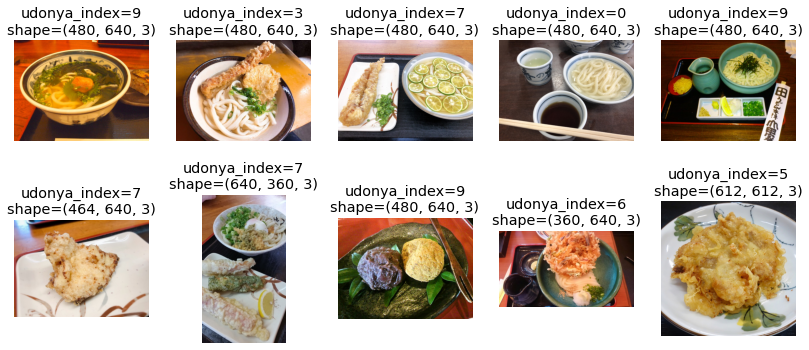

In [11]:
plt.figure(figsize=(14,6))
plt.rcParams["font.size"]=12

# 最初の10個のデータを表示
for i in range(10):
    filepath = train_filepath_list[i]               # train_filepath_listからi番目をfilepathとして取得
    filename = os.path.basename(filepath)           # filepathからファイル名をfilenameを取得
    udonya_index = int(filename.split("_")[0])      # ファイル名からうどん屋の番号udonya_indexを取得　　　　　　　　　
    
    img = cv2.imread(filepath)                      # filepathから画像データを読み込み
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # 色変換 BGR ---> RGB
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)                                               # 画像を表示
    title = f"udonya_index={udonya_index}\nshape={img.shape}"     # タイトル用のテキストを作成
    plt.title(title)                                              # 画像のタイトルを表示
    plt.axis("off")                                               # 目盛を非表示

### DLモデルへの入出力データ（X, Y）の生成
先程作成したファイルパスのリストから1枚ずつ画像を読み込み，画像サイズの調整等を行いながら入出力データ（X, Y）を生成する関数`create_data()`を以下のように定義します。

もともとの画像データはサイズがそろっていません。しかし，MNISTの例で見たように，モデルに入力するためには全て同じサイズにそろえる必要があります。この処理もこの関数の中で行います。



In [12]:
def create_data(filepath_list):
    img_size = (128, 128)                    # 画像サイズの指定
    mode = filepath_list[0].split("/")[1]    # mode: "train" or "valid" or "test"を取得
    print(f"creating {mode} data")

    X = []    # 入力データを入れる空のリストXを作成
    Y = []    # 出力データを入れる空のリストYを作成

    for filepath in tqdm(filepath_list):
        img = cv2.imread(filepath)            # 画像の読み込み
        img = cv2.resize(img, img_size)       # 画像サイズの変更
        img = (img/255.0).astype("float16")   # データ型の変更 int ---> float
        X.append(img)                         # Xに画像データを追加
    
        if mode in ["train", "valid"]:                   # modeが"train"または"valid"の場合の処理
            filename = os.path.basename(filepath)        # filenameを取得
            udonya_index = int(filename.split("_")[0])   # udonya_indexを取得
            Y.append(udonya_index)                       # Yにudonya_indexを追加

    X = np.array(X)     # リストXをnumpy配列に変更
    Y = np.array(Y)     # リストYをnumpy配列に変更

    return X, Y

定義した関数create_data()を使って学習用データ（trainX, trainY, validX, validY, testX）を作成します。

In [13]:
trainX, trainY = create_data(filepath_list = train_filepath_list)
validX, validY = create_data(filepath_list = valid_filepath_list)
testX, _ = create_data(filepath_list = test_filepath_list)

creating train data



creating valid data



creating test data


生成したデータのshapeを確認してみましょう。

In [14]:
print("Data Shape")
print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("validX:", validX.shape)
print("validY:", validY.shape)
print("testX:", testX.shape)

Data Shape
trainX: (10000, 128, 128, 3)
trainY: (10000,)
validX: (500, 128, 128, 3)
validY: (500,)
testX: (500, 128, 128, 3)


### データの保存
一度加工したデータは保存しておけば次回から同じ作業をする手間が省けます。trainX, trainY等は全てNumpy形式のデータなので以下のようにバイナリファイルとして保存することができます。

In [15]:
dataset_name = "udon10_dataset.npz"
dataset_path = os.path.join(working_dir, dataset_name)
np.savez(dataset_path, trainX=trainX, trainY=trainY, validX=validX, validY=validY, testX=testX)

### データの読み込み
作成したデータを一旦メモリから削除して，再度読み込んでみましょう。

まずはデータを削除します。

In [16]:
del trainX, trainY, validX, validY, testX

データを削除したので`trainX`を呼び出してもエラーが出ます。

In [17]:
trainX

NameError: ignored

google driveに保存したデータを再度読み込みます。

In [18]:
data = np.load(dataset_path)    # データの読み込み

trainX = data["trainX"].astype("float32")
trainY = data["trainY"]
validX = data["validX"].astype("float32")
validY = data["validY"]
testX = data["testX"].astype("float32")

データのshapeを表示して正しく読み込まれていることを確認しましょう。

In [19]:
print("Data Shape")
print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("validX:", validX.shape)
print("validY:", validY.shape)
print("testX:", testX.shape)

Data Shape
trainX: (10000, 128, 128, 3)
trainY: (10000,)
validX: (500, 128, 128, 3)
validY: (500,)
testX: (500, 128, 128, 3)


### 読み込んだデータの確認
生成したtrainX, trainYの一部を表示して確認してみましょう。それぞれの画像のタイトルに，正解ラベル(trainY)とデータのサイズを示しています。

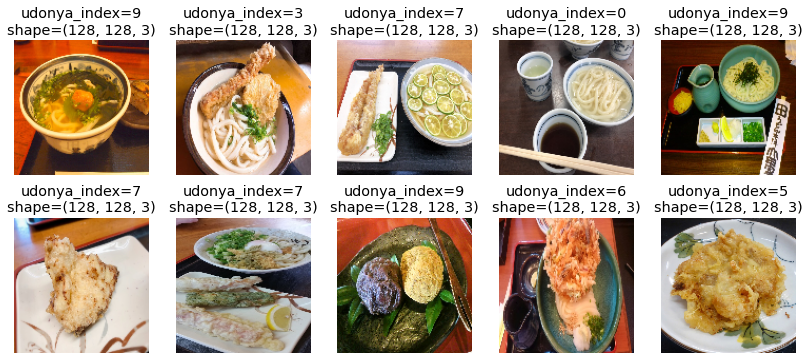

In [20]:
plt.figure(figsize=(14,6))
plt.rcParams["font.size"]=12

# 最初の10個のデータを表示
for i in range(10):
    img = trainX[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    udonya_index = trainY[i]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)                                              # 画像を表示
    title = f"udonya_index={udonya_index}\nshape={img.shape}"    # タイトル用のテキストを作成
    plt.title(title)                                             # 画像のタイトルを表示
    plt.axis("off")

同様にvalidX, validYの一部を表示してみます。

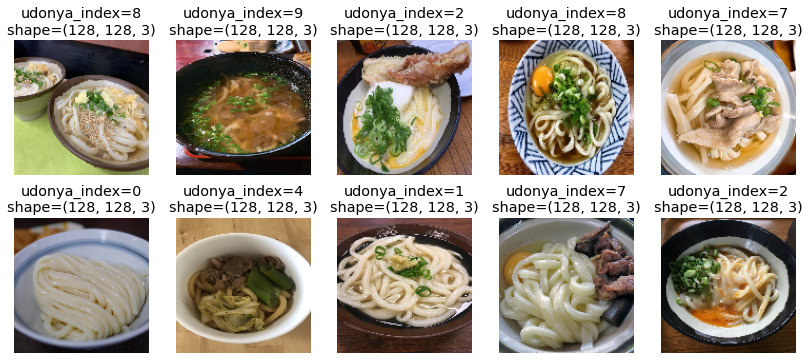

In [21]:
plt.figure(figsize=(14,6))
plt.rcParams["font.size"]=12

# 最初の10個のデータを表示
for i in range(10):
    img = validX[i]
    udonya_index = validY[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)                                                 # 画像を表示
    title = f"udonya_index={udonya_index}\nshape={img.shape}"       # タイトル用のテキストを作成
    plt.title(title)                                                # 画像のタイトルを表示
    plt.axis("off")

同様にtestXを表示します。テストデータには正解ラベルがないのでタイトルにshapeのみを表示しています。

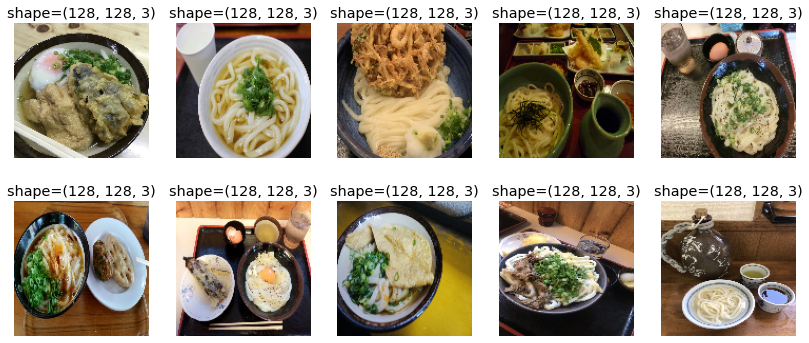

In [22]:
plt.figure(figsize=(14,6))
plt.rcParams["font.size"]=12

# 最初の10個のデータを表示
for i in range(10):
    img = testX[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    title = f"shape={img.shape}"
    plt.title(title)
    plt.axis("off")